In [4]:
from jax import jit, random
import pandas as pd
from datetime import datetime, timedelta
import numpyro
from numpyro import distributions as dist
from numpyro import infer
import arviz as az
from IPython.display import Markdown
from plotly.express.colors import qualitative as qual_colours
from pathlib import Path
import math
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Markdown

from estival.sampling import tools as esamp

from emu_renewal.process import CosineMultiCurve
from emu_renewal.distributions import GammaDens
from emu_renewal.renew import RenewalModel
from emu_renewal.outputs import get_spaghetti_from_params, get_quant_df_from_spaghetti, plot_spaghetti
from emu_renewal.outputs import plot_uncertainty_patches, PANEL_SUBTITLES, plot_3d_spaghetti, plot_post_prior_comparison
from emu_renewal.calibration import StandardCalib
from emu_renewal.utils import get_adjust_idata_index, adjust_summary_cols

from plotting import plot_main_plot
from utils import load_target_data, load_mobility_data, load_vaccination_data, load_variant_prevalence_data

In [5]:
# Set general path
cwd = Path.cwd()
country = 'Malaysia'

In [6]:
# load data
target_data = load_target_data(country)
mobility_data = load_mobility_data(country)
vaccination_data = load_vaccination_data(country)
variant_data = load_variant_prevalence_data(country)

In [4]:
# Specify fixed parameters and get calibration data
proc_update_freq = 21
init_time = 50
data = target_data
pop = 33e6
analysis_start = datetime(2021, 5, 1)
analysis_end = datetime(2022, 4, 30)
init_start = analysis_start - timedelta(init_time)
init_end = analysis_start - timedelta(1)
select_data = data.loc[analysis_start: analysis_end]
init_data = data.resample("D").asfreq().interpolate().loc[init_start: init_end] / 7.0

In [5]:
proc_fitter = CosineMultiCurve()
renew_model = RenewalModel(pop, analysis_start, analysis_end, proc_update_freq, proc_fitter, GammaDens(), init_time, init_data, GammaDens())

In [6]:
# Define parameter ranges
priors = {
    "gen_mean": dist.TruncatedNormal(5.5, 0.5, low=1.0),
    "gen_sd": dist.TruncatedNormal(4.0, 0.5, low=1.0),
    "cdr": dist.Beta(4, 10),
    "rt_init": dist.Normal(0.0, 0.25),
    "report_mean": dist.TruncatedNormal(8, 0.5, low=1.0),
    "report_sd": dist.TruncatedNormal(3, 0.5, low=1.0),
}

In [7]:
#| output: false
calib = StandardCalib(renew_model, priors, select_data, indicator='weekly_sum')
kernel = infer.NUTS(calib.calibration, dense_mass=True, init_strategy=infer.init_to_uniform(radius=0.5))
mcmc = infer.MCMC(kernel, num_chains=2, num_samples=100, num_warmup=100)
mcmc.run(random.PRNGKey(1))

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [8]:
idata = az.from_dict(mcmc.get_samples(True))
idata_sampled = az.extract(idata, num_samples=500)
sample_params = esamp.xarray_to_sampleiterator(idata_sampled)

In [9]:
# get model results and outputs
def get_full_result(gen_mean, gen_sd, proc, cdr, rt_init, report_mean, report_sd):
    return renew_model.renewal_func(gen_mean, gen_sd, proc, cdr, rt_init, report_mean, report_sd)

full_wrap = jit(get_full_result)
panel_subtitles = ["weekly_sum"] + PANEL_SUBTITLES[1:]
spaghetti = get_spaghetti_from_params(renew_model, sample_params, full_wrap, outputs=panel_subtitles)
quantiles_df = get_quant_df_from_spaghetti(renew_model, spaghetti, quantiles=[0.05, 0.5, 0.95], outputs=panel_subtitles)

In [10]:
# Restrict range of mobility and vax data to analysis timeframe
mobility_data = mobility_data.loc[analysis_start:analysis_end]
vaccination_data = vaccination_data.loc[analysis_start:analysis_end]

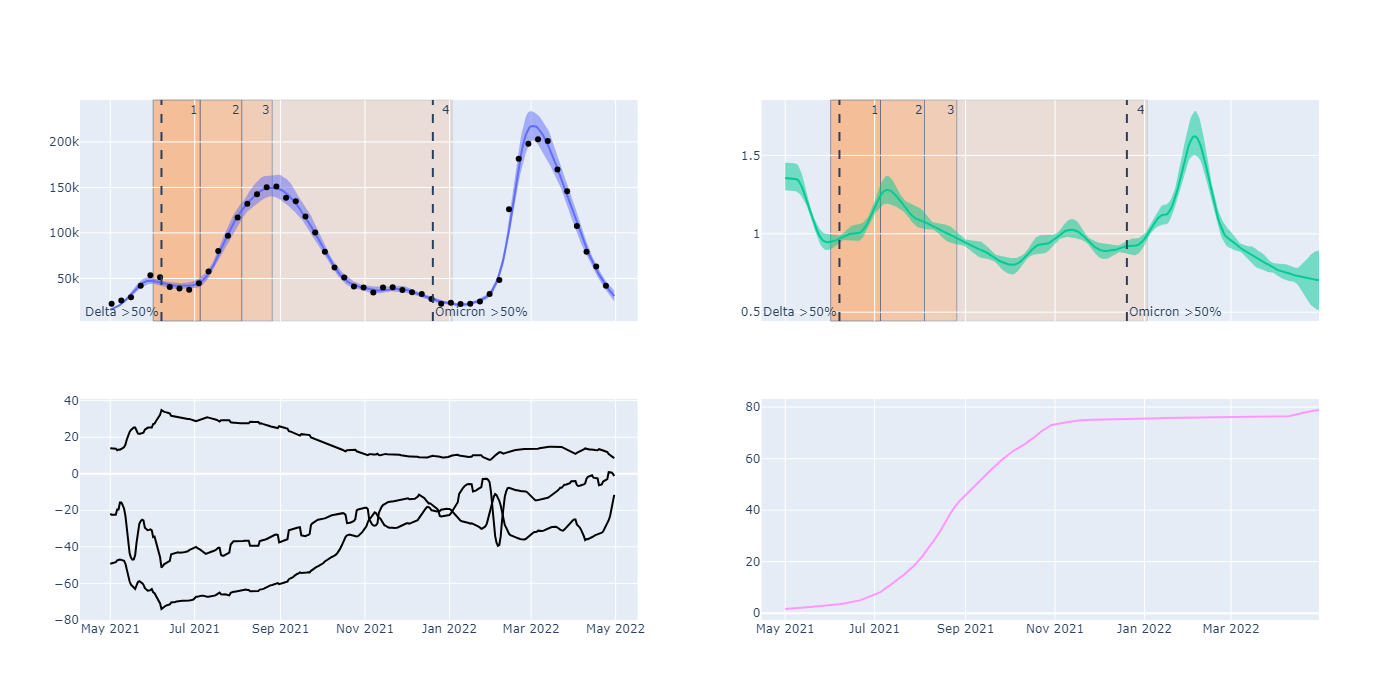

In [43]:
fig = plot_main_plot(quantiles_df, select_data, mobility_data, vaccination_data).update_layout(showlegend=False)

# Add interventions and variant prevalence to plots
number = 2

for i in range(number):
    fig.add_vrect(x0=datetime.strptime("2021-06-01", "%Y-%m-%d").timestamp() * 1000, x1=datetime.strptime("2021-07-05", "%Y-%m-%d").timestamp() * 1000,
             annotation_text="1", annotation_position="top right",
             fillcolor='#FFA15A', opacity=0.60, line_width=0.8, layer='below', row=1, col=i+1)# Phase 1 mco
    fig.add_vrect(x0=datetime.strptime("2021-07-05", "%Y-%m-%d").timestamp() * 1000, x1=datetime.strptime("2021-08-04", "%Y-%m-%d").timestamp() * 1000,
             annotation_text="2", annotation_position="top right",
             fillcolor='#FFA15A', opacity=0.50, line_width=0.8, layer='below', row=1, col=i+1)
    fig.add_vrect(x0=datetime.strptime("2021-08-04", "%Y-%m-%d").timestamp() * 1000, x1=datetime.strptime("2021-08-26", "%Y-%m-%d").timestamp() * 1000,
             annotation_text="3", annotation_position="top right",
             fillcolor='#FFA15A', opacity=0.40, line_width=0.8, layer='below', row=1, col=i+1)
    fig.add_vrect(x0=datetime.strptime("2021-08-26", "%Y-%m-%d").timestamp() * 1000, x1=datetime.strptime("2022-01-03", "%Y-%m-%d").timestamp() * 1000,
             annotation_text="4",
             fillcolor='#FFA15A', opacity=0.20, line_width=0.8, layer='below', row=1, col=i+1)
    
    delta = variant_data[variant_data['variant'] == 'Delta']
    delta_week = delta['week'].to_string(index=False)
    fig.add_vline(x=datetime.strptime(delta_week, "%Y-%m-%d").timestamp() * 1000, 
              annotation_text="Delta >50%", annotation_position="bottom left", row=1, col=i+1, line_dash="dash")
    
    omicron = variant_data[variant_data['variant'] == 'Omicron_BA1_2']
    omicron_week = omicron['week'].to_string(index=False)
    fig.add_vline(x=datetime.strptime(omicron_week, "%Y-%m-%d").timestamp() * 1000, 
              annotation_text="Omicron >50%", annotation_position="bottom right", row=1, col=i+1, line_dash="dash")

fig.show()

In [45]:
Markdown('## Model description')

# Model description

In [9]:
Markdown(renew_model.get_description())



### Fixed parameters
The main analysis period runs from 1<sup>st</sup>  May  2021 to 30<sup>th</sup>  April  2022, with a preceding initialisation period of 50 days. The starting model population is 33.0 million persons. 

### Variable process
Because the analysis period is not an exact multiple of the duration of a process interval, the variable process only starts from day 7 of the analysis. Fitting is implemented using a half-cosine interpolation function that is translated and scaled to reach each of the points specified. This results in a function that joins each two successive requested values with a function that scales smoothly from a gradient of zero at the preceding point to a gradient of zero at the subsequent point. The parameters for the variable process are explored as the update of each process value relative to the preceding value. Each of the parameters for the variable process is exponentiated, such that these parameters are explored in the log-transformed space. 

### Generation times
Probability distribution values for each day are calculated by first finding the parameters needed to construct a gamma distribution with mean and standard deviation equal to those specified by the submitted parameter values. The integrals of the probability density of this distribution between consecutive integer values are then calculated for later combination with the incidence time series. The generation interval for all calculations is truncated from 50 days onwards on the assumption that the distribution's density has reached negligible values once this period has elapsed. 

### Renewal process
Calculation of the renewal process consists of multiplying the incidence values for the preceding days by the reversed generation time distribution values. This follows a standard formula, described elsewhere by several groups,[@cori2013; @faria2021] i.e. $$i_t = R_t\sum_{\tau<t} i_\tau g_{t-\tau}$$
$R_t$ is calculated as the product of the proportion of the population remaining susceptible and the non-mechanistic random process generated external to the renewal model. The susceptible population is calculated by subtracting the number of new incident cases from the running total of susceptibles at each iteration. If incidence exceeds the number of susceptible persons available for infection in the model, incidence is capped at the remaining number of susceptibles. 

### Reporting
Notifications are calculated by first convoling the probability distribution representing the time from onset of an infection episode to reporting with the time series of incidence. This is then multiplied through by the modelled case detection rate to obtain the final time series for case notifications. Probability distribution values for each day are calculated by first finding the parameters needed to construct a gamma distribution with mean and standard deviation equal to those specified by the submitted parameter values. The integrals of the probability density of this distribution between consecutive integer values are then calculated for later combination with the incidence time series. Last, weekly case counts are then calculated from this time series of notifications. 

In [2]:
Markdown('## Prior distributions')

NameError: name 'Markdown' is not defined

### Generation distribution

In [46]:
Markdown('## Calibration')

# Calibration

In [47]:
Markdown(calib.get_description())

The calibration process calibrates parameters for 18 values for periods of the variable process to the data. The relative values pertaining to each period of the variable process are estimated from normal prior distributions centred at no change from the value of the previous stage of the process. The dispersion of the variable process is calibrated, using a half-normal distribution with standard deviation 0.1The log of the modelled notification rate for each parameter set is compared against the data from the end of the run-in phase through to the end of the analysis. Modelled notifications are calculated as the product of modelled incidence and the (constant through time) case detection proportion. The dispersion parameter for this comparison of log values is also calibrated using a half-normal distribution, with standard deviation 0.1. 

In [10]:
summary = az.summary(idata)
#summary = adjust_summary_cols(summary)
#summary.index = summary.index.map(get_adjust_idata_index(renew_model))
#Markdown(summary.to_markdown())

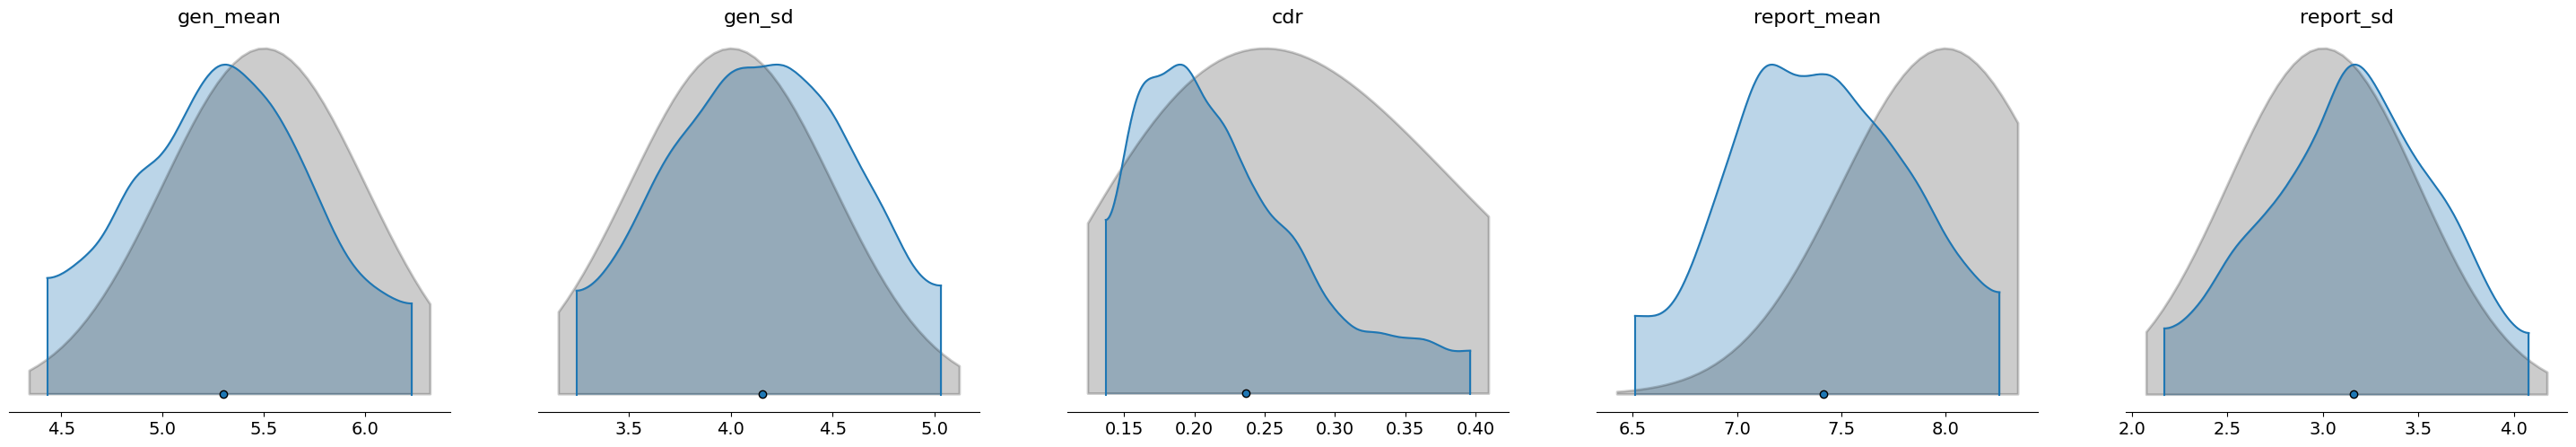

In [17]:
plot_post_prior_comparison(idata, [p for p in priors.keys() if p !="rt_init"],priors);

In [15]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cdr,0.237,0.079,0.137,0.396,0.005,0.004,293.0,203.0,1.01
dispersion,0.091,0.011,0.071,0.111,0.000,0.000,836.0,1165.0,1.00
gen_mean,5.299,0.490,4.428,6.233,0.016,0.011,927.0,1119.0,1.00
gen_sd,4.153,0.490,3.240,5.033,0.013,0.009,1498.0,1534.0,1.00
proc[0],-0.338,0.062,-0.454,-0.225,0.002,0.001,1125.0,988.0,1.00
proc[1],0.077,0.062,-0.042,0.189,0.002,0.001,1408.0,1527.0,1.00
proc[2],0.267,0.063,0.142,0.378,0.002,0.001,1503.0,1266.0,1.00
proc[3],-0.107,0.060,-0.220,0.003,0.002,0.001,1044.0,982.0,1.00
proc[4],-0.013,0.060,-0.118,0.110,0.002,0.001,1237.0,1186.0,1.00
proc[5],-0.036,0.065,-0.158,0.082,0.002,0.001,1142.0,1290.0,1.00


In [ ]:
## James code for calib summary data to table
param_sum = az.summary(idata)
params = [i for i in param_sum.index if not any(s in i for s in ["proc", "rt_init"])]
cols = [i for i in param_sum.columns if not any(s in i for s in ["mcse_"])]
short_param_sum = param_sum.loc[params, cols]
short_param_sum.columns = short_param_sum.columns.str.replace("_", " ").str.replace("ess", "ESS").str.replace("hdi", "HDI")
param_str_conv = {
    "cdr": "CDR",
    "gen_mean": "generation distribution mean (days)",
    "gen_sd": "generation distribution SD (days)",
    "report_mean": "reporting distribution mean (days)",
    "report_sd": "reporting distribution SD (days)",
}
col_str_conv = {
    "r hat": "R-hat",
    "sd": "SD",
}
short_param_sum = short_param_sum.rename(param_str_conv)
short_param_sum = short_param_sum.rename(col_str_conv, axis=1)
short_param_sum

In [75]:
def plot_main_plot(model_data, case_data, mobility_data, vax_data):
    
    # Define elements needed to add case plot
    case_index = case_data.index
    cases = case_data
    
    # Define elements needed to add median line plots
    model_index = model_data.index
    weekly_median = model_data["weekly_sum"][0.50]
    rt_median = model_data["R"][0.50]
    
    
    # Define elements needed for uncertainty plots
    x_vals = model_data.index.to_list() + model_data.index[::-1].to_list()
    y_vals_weekly = model_data["weekly_sum"][0.05].to_list() + model_data["weekly_sum"][0.95][::-1].to_list()
    y_vals_R = model_data["R"][0.05].to_list() + model_data["R"][0.95][::-1].to_list()
    
    # Define elements for mobility plot
    mobility_index = mobility_data.index
    mobility_est = ['transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']
    
    # Define elements for vax plot
    vax_index = vax_data.index
    vax_est = vax_data['people_fully_vaccinated_per_hundred']
                                 
    # Create 2x2 subplot
    fig = make_subplots(2,2, shared_xaxes=True)
    
    # Add modelled case notifications median line
    fig.add_trace(go.Scatter(x=model_index, y=weekly_median, mode="lines", name="Modelled cases", marker_color='#636EFA' ), row=1, col=1)
    # Add modelled case notifications uncertainty
    fig.add_trace(go.Scatter(x=x_vals, y=y_vals_weekly, mode="lines", name="Modelled cases", line={"width": 0.0, "color": '#636EFA'}, fill='toself', showlegend=False ), row=1, col=1)
    
    # Add case notifications
    fig.add_trace(go.Scatter(x=case_index, y=cases,  mode="markers", name="Reported cases", marker_color="black" ), row=1, col=1)
    
    # Add Rt median line
    fig.add_trace(go.Scatter(x=model_index, y=rt_median, mode="lines", name="Rt", marker_color='#00CC96' ), row=1, col=2)
    # Add Rt uncertainty 
    fig.add_trace(go.Scatter(x=x_vals, y=y_vals_R, mode="lines", name="Rt", line={"width": 0.0, "color": '#00CC96'}, fill='toself', showlegend=False ), row=1, col=2)
    
    # Add mobility figure
    for i in mobility_est:
        fig.add_trace(go.Scatter(x=mobility_data.index, y=mobility_data[i], mode="lines", name="Mobility", line={"color": 'black'}), row=2, col=1)
    
    # Add vaccination figure
    fig.add_trace(go.Scatter(x=vax_data.index, y=vax_est, mode="lines", name="Vaccination",), row=2, col=2)
    
                                 
    return fig

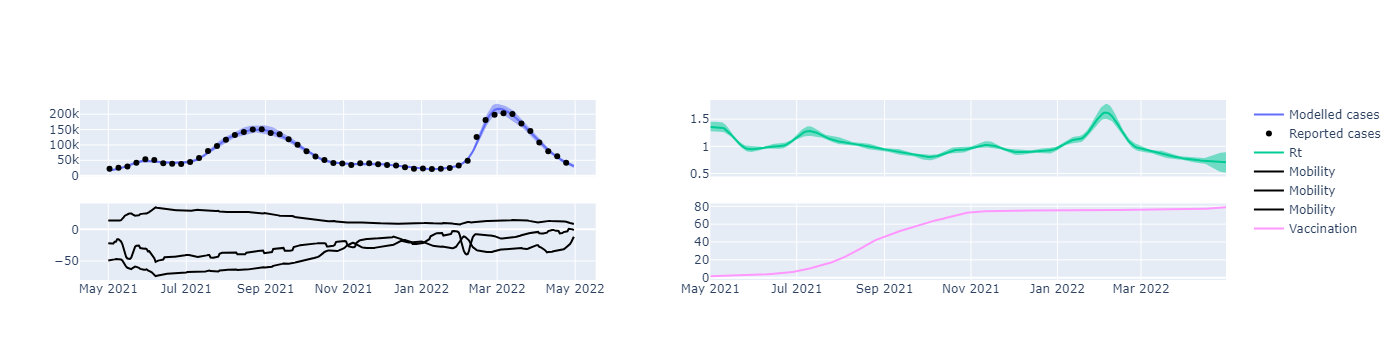

In [76]:
plot_main_plot(quantiles_df, select_data, mobility_data, vaccination_data) 